In [37]:
import numpy as np
import matplotlib.pyplot as plt
import unittest
from unittest.mock import patch
import dascore as dc
from dascore.utils.downloader import fetch


In [38]:
def compute_sta(timeseries, samplingrate, stawindowduration): #short term average of the signal over a window duration
    stawindowlength = int(stawindowduration * samplingrate)
    stavalues = np.array([np.mean(np.abs(timeseries[i:i+stawindowlength])) 
                          for i in range(len(timeseries) - stawindowlength)])
    return stavalues

def compute_lta(timeseries, samplingrate, ltawindowduration): #long term average of the signal over a window duration 
    ltawindowlength = int(ltawindowduration * samplingrate)
    ltavalues = np.array([np.mean(np.abs(timeseries[i:i+ltawindowlength])) 
                          for i in range(len(timeseries) - ltawindowlength)])
    return ltavalues

def compute_ratio(stavalues, ltavalues): #the ratio of STA to LTA values to identify events
    min_length = min(len(stavalues), len(ltavalues))
    stavalues = stavalues[:min_length]
    ltavalues = ltavalues[:min_length]
    ratio = np.maximum(stavalues / ltavalues, 1)    
    return ratio

def detect_events(ratio, detection_threshold, samplingrate): #identifies events based on STA/LTA ratio exceeding a detection threshold 
    min_event_duration_samples = int(0.05 * samplingrate)
    min_event_separation_samples = int(0.5 * samplingrate)
    events = []
    event_active = False
    event_start = None

    for i in range(len(ratio)):
        if ratio[i] > detection_threshold:
            if not event_active:
                event_start = i
                event_active = True
        else:
            if event_active:
                event_end = i
                event_active = False
                if event_end - event_start >= min_event_duration_samples:
                    if len(events) == 0 or event_start - events[-1][1] >= min_event_separation_samples:
                        events.append((event_start, event_end))

    return events

def staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold): #integrates the above functions to compute STA,LTA, ratio and detect events in the timeseries 
    stavalues = compute_sta(timeseries, samplingrate, stawindowduration)
    ltavalues = compute_lta(timeseries, samplingrate, ltawindowduration)
    ratio = compute_ratio(stavalues, ltavalues)
    events = detect_events(ratio, detection_threshold, samplingrate)
    return stavalues, ltavalues, ratio, events


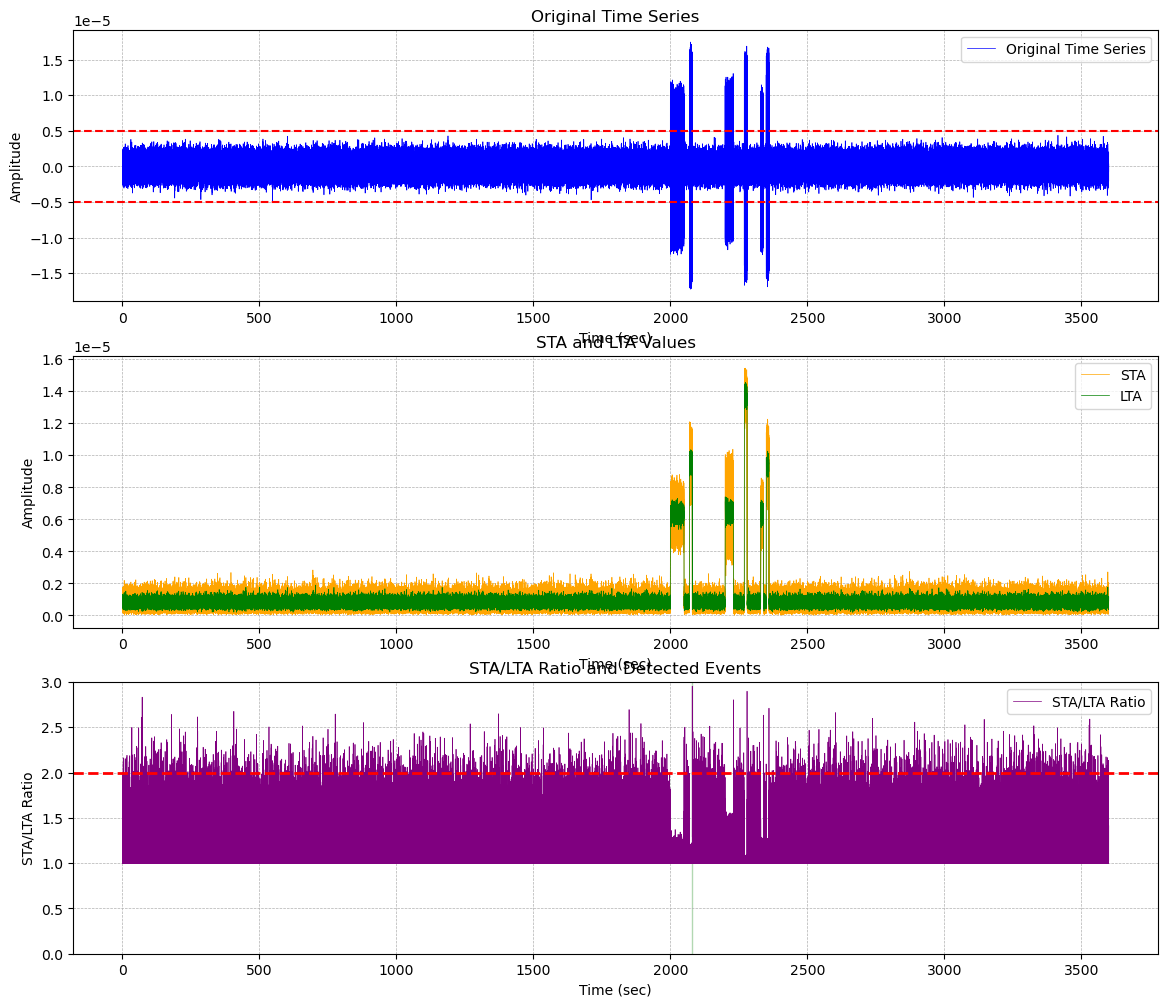

In [39]:
samplingrate = 100.0
duration = 3600  # seconds
t = np.linspace(0, duration, int(duration * samplingrate)) #time vector t that spans from 0 to 3600 seconds with a total of int(duration * samplingrate) points. linsapce creates a llinearly spaced array of time spoints. this array is used to simulate the axis for synthetic data to ensure that each sample has a timestamp
np.random.seed(0) 
background_noise = np.random.normal(0, 1e-6, len(t)) #background noise as a normal (gaussian) distribution with a mean of 0 and a sd of 1 * 10^-6 with the same length as the time vector 't'
timeseries = background_noise.copy() #timeseries variable will be used as the main input for the STA/LTA algorithm. 

# Add synthetic seismic events added to the timeseries at specific indices with varying frequencies and amplitudes to simulate seismic events 
event_indices = [(2000, 2050), (2070, 2080), (2200, 2230), (2270, 2280), (2330, 2340), (2350, 2360)]
event_frequencies = [20, 30, 40, 50, 20, 30]
event_amplitudes = [10e-6, 15e-6, 10e-6, 15e-6, 10e-6, 15e-6]

for (start, end), freq, amp in zip(event_indices, event_frequencies, event_amplitudes):
    start_idx = int(start * samplingrate)
    end_idx = int(end * samplingrate)
    event_time = t[start_idx:end_idx]
    timeseries[start_idx:end_idx] += amp * np.sin(2 * np.pi * freq * event_time)

# Run the STA/LTA trigger, staltatrigger function is called with the generated timeseries and parameters such as STA and LTA window durations, step size durations and detection threshold 
stawindowduration = 0.03
ltawindowduration = 0.1
stepsizeduration = 0.01
detection_threshold = 2.0
sta, lta, ratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

# Adjust lengths of the time arrays
ltawindowlength = int(ltawindowduration * samplingrate)
time_stalta = t[ltawindowlength:ltawindowlength + len(ratio)]

# Plot the results
plt.figure(figsize=(14, 12))

# Plot the original timeseries
plt.subplot(3, 1, 1)
plt.plot(t, timeseries, label='Original Time Series', color='blue', linewidth=0.5)
plt.axhline(y=5e-6, color='r', linestyle='--')
plt.axhline(y=-5e-6, color='r', linestyle='--')
plt.title('Original Time Series')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Plot STA and LTA values
plt.subplot(3, 1, 2)
plt.plot(time_stalta, sta[:len(time_stalta)], label='STA', color='orange', linewidth=0.5)
plt.plot(time_stalta, lta[:len(time_stalta)], label='LTA', color='green', linewidth=0.5)
plt.title('STA and LTA Values')
plt.xlabel('Time (sec)')
plt.ylabel('Amplitude')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Plot STA/LTA ratio and detected events
plt.subplot(3, 1, 3)
plt.plot(time_stalta, ratio, label='STA/LTA Ratio', color='purple', linewidth=0.5)
plt.axhline(y=detection_threshold, color='red', linestyle='--', linewidth=2)  # Add detection threshold line
plt.title('STA/LTA Ratio and Detected Events')
plt.xlabel('Time (sec)')
plt.ylabel('STA/LTA Ratio')
plt.ylim(0, 3)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()

# Mark detected events
for event in events:
    plt.axvspan(time_stalta[event[0]], time_stalta[event[1]], color='green', alpha=0.3)

plt.show()

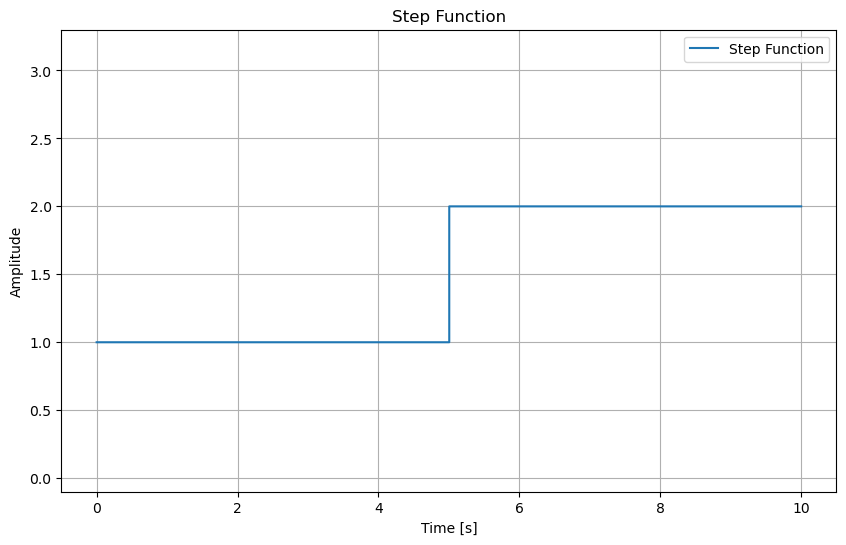

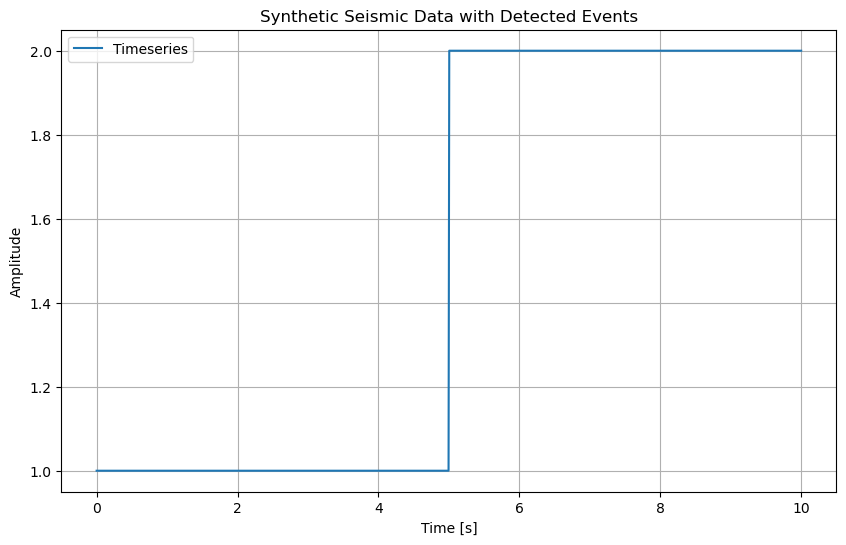

In [24]:

# Generate synthetic seismic data
samplingrate = 100.0
duration = 10  # seconds
num_samples = int(duration * samplingrate)  # Ensure this is an integer
t = np.linspace(0, duration, num_samples)  # Time vector

# Function to generate step function values
def stepfunction(timeseries): #timeseries: an array representing the time points or the input signal data
    return np.where(timeseries > 5, 2, 1) #outputting 2 for tiimes greater than 5 seconds and 1 otherwise

# Generate background noise
np.random.seed(0)  
background_noise = np.random.normal(0, 1e-6, num_samples)  #normally distributed noise added to timeseries to simulate random seismic background activity
step_values = stepfunction(t)
timeseries = background_noise + step_values #combination of background noise and step function values 

# Plot the step function
plt.figure(figsize=(10, 6)) 
plt.plot(t, step_values, label='Step Function', drawstyle='steps-post') 
plt.title('Step Function') 
plt.xlabel('Time [s]') 
plt.ylabel('Amplitude') 
plt.ylim(-0.1, 3.3) 
plt.grid(True) 
plt.legend()
plt.show()

# Parameters for STA/LTA
stawindowduration = 0.03
ltawindowduration = 0.1
stepsizeduration = 0.01
detection_threshold = 2.0

# Compute STA/LTA and detect events based on the ratio exceeding the threshold 
sta, lta, ratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

# Plot the timeseries and detected events
plt.figure(figsize=(10, 6))
plt.plot(t, timeseries, label='Timeseries')
for start, end in events:
    plt.axvspan(t[start], t[end], color='red', alpha=0.3, label='Detected Event' if start == events[0][0] else "")
plt.title('Synthetic Seismic Data with Detected Events')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()


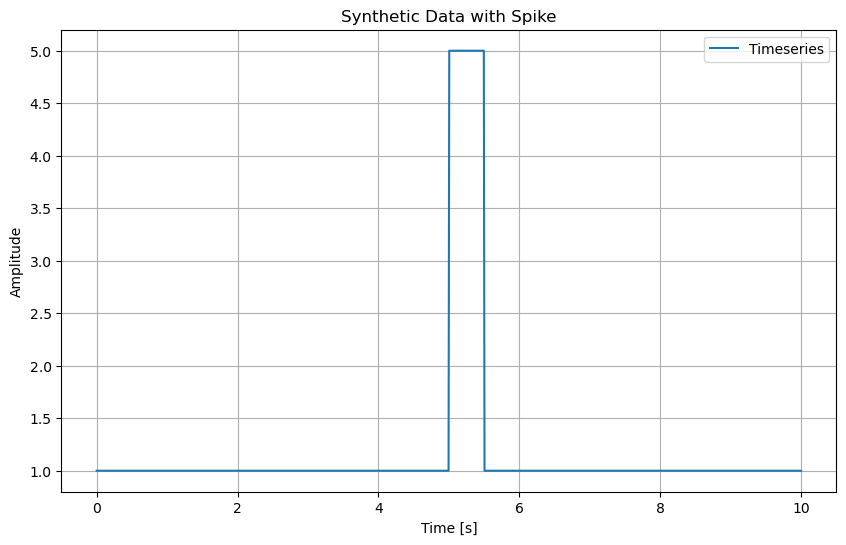

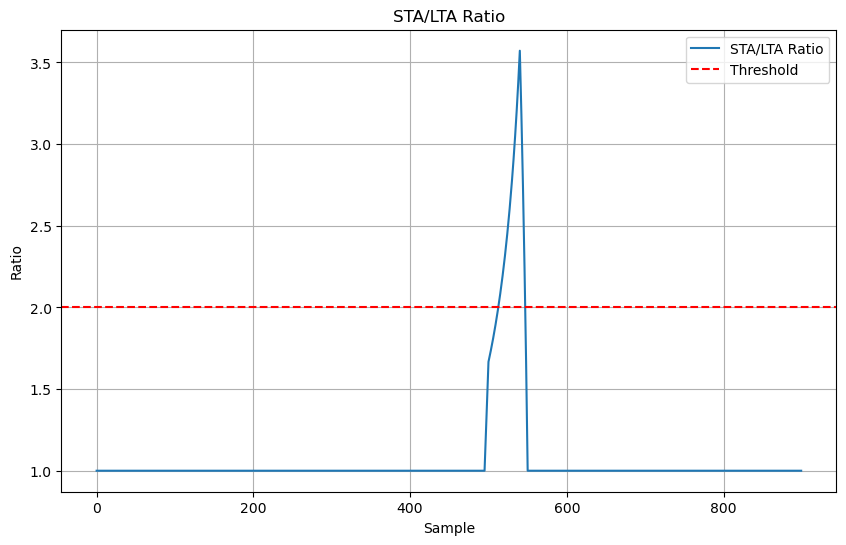

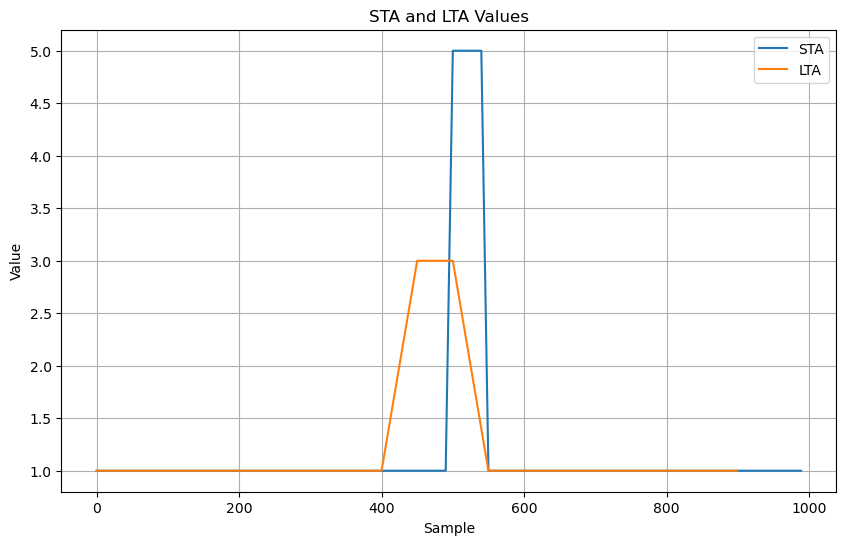

.
----------------------------------------------------------------------
Ran 1 test in 0.237s

OK


Max STA/LTA Ratio: 3.571428949673925
STA values around the spike: [1.00000014 1.40000028 1.80000031 2.20000031 2.60000016 2.99999985
 3.3999998  3.7999997  4.1999996  4.59999958 4.99999972 4.99999977
 4.99999991 4.99999967 4.9999995  4.99999946 4.99999954 4.99999975
 5.00000002 5.00000016 5.00000021 5.00000009 4.99999987 4.99999983
 4.99999994 5.00000003 4.99999992 4.99999997 5.         4.99999974
 4.99999965 4.99999945 4.99999958 4.99999987 4.99999996 4.99999981
 4.99999984 4.99999972 4.99999956 4.99999978 4.99999968 4.99999993
 4.99999977 4.99999962 4.99999977 4.99999986 4.99999987 5.
 4.99999977 4.9999999  4.99999985 4.59999985 4.19999998 3.8000001
 3.39999992 2.99999989 2.60000006 2.19999972 1.79999998 1.39999972
 0.99999971 0.99999989 0.99999988 0.99999981 0.99999965 0.99999965
 0.99999954 0.99999981 0.99999987 1.00000001]
LTA values around the spike: [2.99999982 2.99999984 2.99999985 2.99999984 2.99999981 2.99999979
 2.99999979 2.99999979 2.9999998  2.9999998  2.9999998  2.959999

In [25]:

# Define the test class
class TestSTALTA(unittest.TestCase):

    def test_stalta_detection(self):
        # Parameters
        samplingrate = 100.0
        duration = 10  # seconds
        num_samples = int(duration * samplingrate)  # Ensure this is an integer
        stawindowduration = 0.1
        ltawindowduration = 1.0
        stepsizeduration = 0.01
        detection_threshold = 2.0  # Set the threshold to 2.0 for this test

        # Generate synthetic data
        t = np.linspace(0, duration, num_samples)  # Time vector
        
        # Create a spike in the data
        timeseries = np.ones(num_samples)  # Start with a constant value
        spike_start = int(5 * samplingrate)  # Start the spike at 5 seconds
        spike_end = spike_start + int(0.5 * samplingrate)  # End the spike at 5.5 seconds
        timeseries[spike_start:spike_end] = 5  # Set the value to 5 during the spike (higher value to ensure ratio > 2)
        
        # Adjust the timeseries to ensure the STA/LTA ratio exceeds 2 during the spike
        timeseries[:spike_start] = 1
        
        # Generate background noise
        np.random.seed(0)
        background_noise = np.random.normal(0, 1e-6, num_samples)
        timeseries += background_noise

        # Run STA/LTA detection
        sta, lta, ratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

        # Plot the step function and timeseries
        plt.figure(figsize=(10, 6))
        plt.plot(t, timeseries, label='Timeseries')
        plt.title('Synthetic Data with Spike')
        plt.xlabel('Time [s]')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the STA/LTA ratio
        plt.figure(figsize=(10, 6))
        plt.plot(ratio, label='STA/LTA Ratio')
        plt.axhline(detection_threshold, color='r', linestyle='--', label='Threshold')
        plt.title('STA/LTA Ratio')
        plt.xlabel('Sample')
        plt.ylabel('Ratio')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot the STA and LTA values
        plt.figure(figsize=(10, 6))
        plt.plot(sta, label='STA')
        plt.plot(lta, label='LTA')
        plt.title('STA and LTA Values')
        plt.xlabel('Sample')
        plt.ylabel('Value')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Print debug information
        print(f"Max STA/LTA Ratio: {max(ratio)}")
        print(f"STA values around the spike: {sta[spike_start-10:spike_end+10]}")
        print(f"LTA values around the spike: {lta[spike_start-10:spike_end+10]}")

        # Assertions, https://www.geeksforgeeks.org/python-assertgreaterequal-function-in-unittest/
        self.assertGreaterEqual(max(ratio), detection_threshold, "The STA/LTA ratio should reach at least the detection threshold")
        self.assertGreater(len(events), 0, "There should be at least one detected event")
        
        # Verify the timing of the detected events
        for start, end in events:
            self.assertTrue(np.any(ratio[start:end] >= detection_threshold), "The STA/LTA ratio should be above the threshold during the detected event")

# Run the tests
if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)


In [7]:
#confirm that the STA/LTA ratio reaches the detection threshold 
#ensure at least one event is detected
#verify that the STA/LTA ratio is above the threshold during detected events
#check that the STA/LTA values are non-negative

# Define the staltatrigger function if it's not imported from an external module
import numpy as np 
import unittest

def staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold):
    num_samples = len(timeseries) #timeseries, input signal data
    sta_samples = int(stawindowduration * samplingrate) #number of samples per second
    lta_samples = int(ltawindowduration * samplingrate)
    step_samples = int(stepsizeduration * samplingrate) #threshold value for detecting events
    
    sta = np.zeros(num_samples) #initialize arrays to store STA, LTA and ratio values
    lta = np.zeros(num_samples)
    ratio = np.zeros(num_samples)
    
    for i in range(lta_samples, num_samples, step_samples):
        sta[i] = np.mean(timeseries[i-sta_samples:i])
        lta[i] = np.mean(timeseries[i-lta_samples:i])
        if lta[i] > 0:
            ratio[i] = sta[i] / lta[i]
    
    events = []
    event_start = None
    for i in range(num_samples):
        if ratio[i] >= detection_threshold and event_start is None:
            event_start = i
        elif ratio[i] < detection_threshold and event_start is not None:
            events.append((event_start, i))
            event_start = None
    
    return sta, lta, ratio, events

class TestSTALTA(unittest.TestCase): #purpose: to test the staltatrigger function using synthetic data

    def test_stalta_detection(self): 
        # Parameters
        samplingrate = 100.0
        duration = 10  # seconds
        num_samples = int(duration * samplingrate)  # Ensure this is an integer
        stawindowduration = 0.1
        ltawindowduration = 1.0
        stepsizeduration = 0.01
        detection_threshold = 2.0  # Set the threshold to 2.0 for this test

        # Generate synthetic data
        t = np.linspace(0, duration, num_samples)  # Time vector and a timeseries with a constant value, introduces a spike in the data to simulate seismic event and adds background noise to the timeseries
        
        # Create a spike in the data, the maximum sta/lta ratio should reach at least the detectino threshold, 
        timeseries = np.ones(num_samples)  # Start with a constant value
        spike_start = int(5 * samplingrate)  # Start the spike at 5 seconds
        spike_end = spike_start + int(0.5 * samplingrate)  # End the spike at 5.5 seconds
        timeseries[spike_start:spike_end] = 5  # Set the value to 5 during the spike (higher value to ensure ratio > 2)
                
        # Generate background noise
        np.random.seed(0)
        background_noise = np.random.normal(0, 1e-6, num_samples) 
        timeseries += background_noise

        # Purpose: this line calls the 'staltatrigger' function with the generated timeseries and the specified parameters 
        sta, lta, ratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

        

        #Additional test to run all values in the STA/LTA arrays are non-negative
        self.assertTrue(np.all(sta >= 0), "STA values should be non-negative")
        self.assertTrue(np.all(lta >= 0), "LTA values should be non-negative") 

# Run the tests
if __name__ == "__main__":
    unittest.main(argv=[''], exit=False)
#the sta/lta ratio reached or exceeded the detection threshold 
#at least one event was detected
#during detected events, the sta/lta ratio was above the threshold 
#sta and lta values are non-negative


.
----------------------------------------------------------------------
Ran 1 test in 0.009s

OK


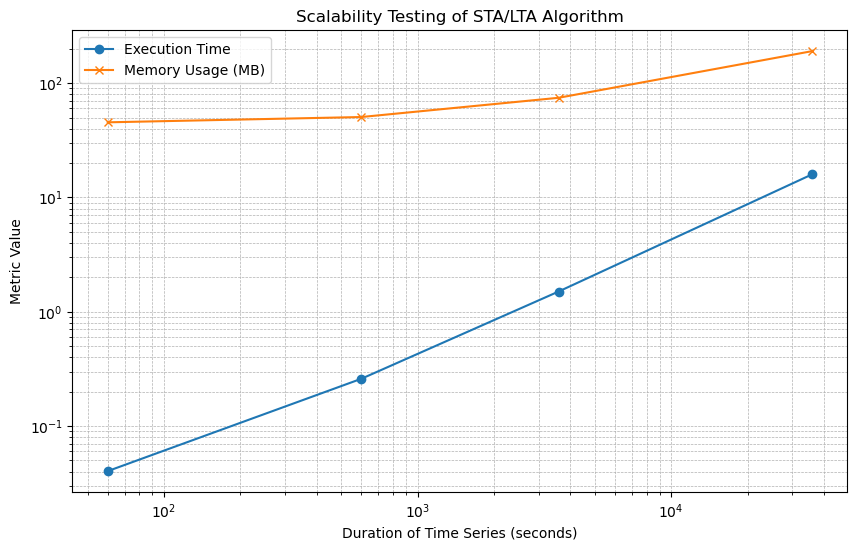

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import time #measuring the execution time 
import psutil #monitoring system resource usage (e.g. memory usage) 
import pandas as pd #handling and analyzing data  

def compute_sta(timeseries, samplingrate, stawindowduration): #compute the STA and LTA of the time series data 
    stawindowlength = int(stawindowduration * samplingrate)
    stavalues = np.array([np.mean(np.abs(timeseries[i:i+stawindowlength])) 
                          for i in range(len(timeseries) - stawindowlength)])
    return stavalues

def compute_lta(timeseries, samplingrate, ltawindowduration):
    ltawindowlength = int(ltawindowduration * samplingrate)
    ltavalues = np.array([np.mean(np.abs(timeseries[i:i+ltawindowlength])) 
                          for i in range(len(timeseries) - ltawindowlength)])
    return ltavalues

def compute_ratio(stavalues, ltavalues):
    min_length = min(len(stavalues), len(ltavalues))
    stavalues = stavalues[:min_length]
    ltavalues = ltavalues[:min_length]
    ratio = np.maximum(stavalues / ltavalues, 1)  # Ensure ratio doesn't go below 1
    return ratio

def detect_events(ratio, detection_threshold, samplingrate): #iterates through the STA/LTA ratio values and identifies periods where teh ratio exceeds teh detection threshold, marking the start and end of potential events. 
    min_event_duration_samples = int(0.05 * samplingrate)
    min_event_separation_samples = int(0.5 * samplingrate)
    events = []
    event_active = False
    event_start = None

    for i in range(len(ratio)):
        if ratio[i] > detection_threshold:
            if not event_active:
                event_start = i
                event_active = True
        else:
            if event_active:
                event_end = i
                event_active = False
                if event_end - event_start >= min_event_duration_samples:
                    if len(events) == 0 or event_start - events[-1][1] >= min_event_separation_samples:
                        events.append((event_start, event_end))

    return events

def staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold):
    stavalues = compute_sta(timeseries, samplingrate, stawindowduration)
    ltavalues = compute_lta(timeseries, samplingrate, ltawindowduration)
    ratio = compute_ratio(stavalues, ltavalues)
    events = detect_events(ratio, detection_threshold, samplingrate)
    return stavalues, ltavalues, ratio, events

 #executes the scalability test that measures teh execution time and memory usage for different durations of time series data
samplingrate = 100.0  # Hz
durations = [60, 600, 3600, 36000]  # 1 minute, 10 minutes, 1 hour, 10 hours
stawindowduration = 0.03
ltawindowduration = 0.1
stepsizeduration = 0.01
detection_threshold = 2.0



#run the sta/lta algorithm on synthetic data for different durations,measuring the execution time and memory usage
#steps: generate a time vector ('t') for each duration 
#add a background noise and synthetic seismic events to the time series
# measure the execution time of the STA/LTA algorithm 
#measure memory usage using psutil 
#collect results(duration, execution time and memory usage) in a list of dictionaries
def execute_scalability_test(durations, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold):
    results = [] 

    for duration in durations:
        t = np.linspace(0, duration, int(duration * samplingrate))
        np.random.seed(0)
        background_noise = np.random.normal(0, 1e-6, len(t))
        timeseries = background_noise.copy()

        # Add synthetic seismic events
        event_indices = [(2000, 2050), (2070, 2080), (2200, 2230), (2270, 2280), (2330, 2340), (2350, 2360)]
        event_frequencies = [20, 30, 40, 50, 20, 30]
        event_amplitudes = [10e-6, 15e-6, 10e-6, 15e-6, 10e-6, 15e-6]

        for (start, end), freq, amp in zip(event_indices, event_frequencies, event_amplitudes):
            start_idx = int(start * samplingrate)
            end_idx = int(end * samplingrate)
            event_time = t[start_idx:end_idx]
            timeseries[start_idx:end_idx] += amp * np.sin(2 * np.pi * freq * event_time)

        # Measure execution time and resource usage
        start_time = time.time()
        sta, lta, ratio, events = staltatrigger(timeseries, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)
        end_time = time.time()
        execution_time = end_time - start_time

        # Capture memory usage
        process = psutil.Process() #provides an easy way to monitor system resource usage. Here, psuit measures the memory consumption of the process running the STA/LTA algorithm. 
        memory_info = process.memory_info() #understanding how memory usage scales with input size
        memory_usage = memory_info.rss / (1024 ** 2)  # in MB, used to convert memory usage from bytes to megabytes. 

        results.append({ #during execution, each result is collected in a list of dictionaries. each dictionary contains teh duration, execution time and memory usage 
            'duration': duration,
            'execution_time': execution_time,
            'memory_usage': memory_usage
        })

    return pd.DataFrame(results) #the dataframe is used to plot the results, showing how execution time and memory usage scale with duration of the time series. 

# Execute the scalability test. Results_df is a pandas.DataFrame object that provides a convenient way to store and manipulate data. It also allows you to organize the results in a structures format
results_df = execute_scalability_test(durations, samplingrate, stawindowduration, ltawindowduration, stepsizeduration, detection_threshold)

# Plot the scalability results, 
plt.figure(figsize=(10, 6))
plt.plot(results_df['duration'], results_df['execution_time'], marker='o', label='Execution Time')
plt.plot(results_df['duration'], results_df['memory_usage'], marker='x', label='Memory Usage (MB)')
plt.title('Scalability Testing of STA/LTA Algorithm')
plt.xlabel('Duration of Time Series (seconds)')
plt.ylabel('Metric Value')
plt.xscale('log')
plt.yscale('log')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()



Running DASDAE tests...


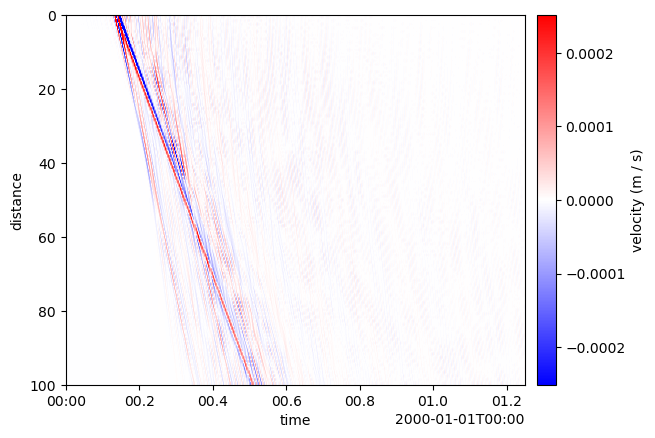

In [23]:

# Function to run all the tests 
def run_tests():
    print("Running DASDAE tests...")

    # Fetching example data
    # directory_patch = fetch('test_dasdae.py').parent
    # spool = dc.get_example_spool('diverse_das')

    #fetches an example patch
    patch = dc.get_example_patch('dispersion_event') #Registered example patches are ['random_das', 'patch_with_null', 'random_patch_with_lat_lon', 'wacky_dim_coords_patch', 'sin_wav', 'example_event_1', 'example_event_2', 'ricker_moveout', 'dispersion_event']

    patch.viz.waterfall(show=True, scale=0.2); 
if __name__ == "__main__": 
    run_tests()
    #the run test function is called only when the script is run directly, not when it's imported 
